In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy
import gammapy
print(gammapy.__version__)
print(np.__version__)

from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region

0.18.2
1.19.4


Access the Data:

PATH TO DATASTORE: .fits files and the hdu-index and the obs_table. The tables are already accessible via data_store.obs_table and data_store.hdu_table. 

Also, make sure that the path to the obs fits files is correct in the hdu_table. 

In [2]:
data_store = DataStore.from_dir("/Users/cedrickperron/GAMMAPY/LS5039_new")
s = data_store.hdu_table.read("/Users/cedrickperron/GAMMAPY/LS5039_new/hdu-index.fits.gz")
OBS_table = data_store.obs_table.read("/Users/cedrickperron/GAMMAPY/LS5039_new/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
s.remove_column("FILE_DIR")
s.add_column("/Users/cedrickperron/GAMMAPY/LS5039_new", name="FILE_DIR")


In the obs_table, there is a column called OBS_ID (Check this via: print(data_store.obs_table["OBS_ID"]). Access this column and call it the obs_id.

Also, you can get the observations of the data_store, which is a very important step (see the equivalent of this in the config). NOTE: You do not have the bkg here (as expected), which means that you will need to create your own background with the BackgroundMaker.

In [3]:
data_store.hdu_table = s
hdu_table = data_store.hdu_table
data_store.obs_table
print(data_store.hdu_table)

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]

#print(obs_id)

# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)


No HDU found matching: OBS_ID = 69123, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69187, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69188, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69202, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69203, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73193, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73213, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73234, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73300, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73317, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73335, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73356, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73357, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73370, HDU_TYPE = bkg, HDU_CLASS

OBS_ID HDU_TYPE ...      HDU_NAME                     FILE_DIR               
------ -------- ... ----------------- ---------------------------------------
 69123   events ...            EVENTS /Users/cedrickperron/GAMMAPY/LS5039_new
 69123      gti ...               GTI /Users/cedrickperron/GAMMAPY/LS5039_new
 69123     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/LS5039_new
 69123    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/LS5039_new
 69123      psf ...               PSF /Users/cedrickperron/GAMMAPY/LS5039_new
 69187   events ...            EVENTS /Users/cedrickperron/GAMMAPY/LS5039_new
 69187      gti ...               GTI /Users/cedrickperron/GAMMAPY/LS5039_new
 69187     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/LS5039_new
 69187    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/LS5039_new
 69187      psf ...               PSF /Users/cedrickperron/GAMMAPY/LS5039_new
   ...      ... ...               ...                           

Identifying the target region and defining the on_region

In [4]:
target_position=SkyCoord(276.562, -14.825, unit="deg",frame="icrs")

on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

Identify the geom parameter of the Dataset (see the config equivalent). Also, identify the exclusion region. Note there is an additional one: the HESS.


**Note that there is a difference between 3D and 1D Map here. The 3D maps involve the energy axis while the 1D map does not.**

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff6368861d0>)

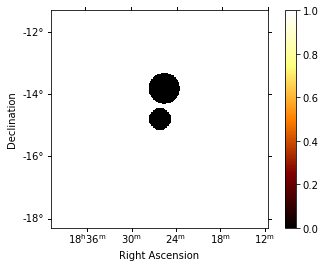

In [6]:
# Build the energy axis: Note that we take the energy boundary found in the ...
# I guess the most important thing here is to at least take large enough bounds to get all the data, but there is a threshold to consider...
energy_axis = MapAxis.from_energy_bounds(0.400, 40, 15, unit= "TeV", name="energy")
# Assuming the range of the true energy axis is the same as the energy axis, which is reasonable if you take the large energy bounds
true_energy_axis = MapAxis.from_energy_bounds(0.200, 70, 20, unit= "TeV", name="energy_true")




# Geom: The parameters were taken from the run_parameter file, except the width (supposed to be (2,2)), but it is too small for some reason
#FOR 3D: axes=[energy_axis]
"""geom = WcsGeom.create(skydir=target_position, binsz=0.02, width=(5,5), proj="CAR",axes=[energy_axis])"""
#FOR 1D: Only Spatial

geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
#geom = WcsGeom.create(skydir=target_position, binsz=0.01, width=(5,5), proj="CAR",axes=[energy_axis])

#Add the exclusion region of the HESS SOURCE (276.421,-13.8389, 0.50) per runparameter file
hess_region = make_region("icrs;circle(276.421,-13.8389, 0.50)")





""" FOR 3D
    geom.to_image() -> geom is a WcsGeom type (which is a gammapy.Map object).
    geom.to_image() produces a 2D map of spatial dimensions only. to_cube appends an 
    energy axis. The squash() method reduces the energy axis to one bins.
CODE:
geom_image=geom.to_image().to_cube([energy_axis.squash()])
"""
# FOR 1D: (No energy axis)
geom_image = geom.to_image()

#geom_image=geom.to_image().to_cube([energy_axis.squash()])




""" The exclusion_mask will be plotted as a Map object, which has 2 parameters:
    geom => Need an object of type WcsGeom (geom or geom.to_image()). 
    data => The region_mask: It is a parameter of the geom (object of type WcsGeom) and it is itself a numpy array
"""
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
exclusion_mask=Map.from_geom(geom_image)
# Note Inside = True => Then all the regions outside will not have any pixels. False => Region inside have no pixel
exclusion_mask.data=geom_image.region_mask([hess_region, center_region], inside=False)
# No pixel => Energy => 0 (no signal)
exclusion_mask.sum_over_axes().plot(add_cbar=True)


For 1D dataset, we need to have a dataset that does not include the energy. (**See Doc 9**)


The way that ReflectedRegionsBackgroundMaker works is by building reflected regions. Basically, below, you enter the information that will find the reflected regions of each run. This step is not important, but it is useful when you got a bug while performing bkg_maker.run().

Each Reflected regions add to the acceptance_off by 1 and build up a unique count_off map. In the ReflectedRegionsBackgroundMaker, you got some optimal parameters and here is what they do:
    
    angle_increment: The way that the reflected regions are found in the finder is through a while loop, where you have a max_angle that is given by your obs and you also have a curr_angle that is also given by the obs. while curr_angle < max_angle, then you will create a reflected region (depending on certain conditions satisfied determined by your other parameters). Each time you perform the loop, you add an increment to the curr_angle: curr_angle += angle_increment.
    min_distance : `~astropy.coordinates.Angle`, optional
       Minimal distance between two consecutive reflected regions
    min_distance_input :
       Minimal distance from input region (This, in my opinion, is the minimum distance between the on_region and where your reflected region can be. Note that the reflected region will not be created if the regions touches the on_region. By region, I mean the circle
       
    max_region_number : This is the maximum # of reflected regions that you have. This is useful, because sometime you over-estimate the bkg.
    exclusion_mask : `~gammapy.maps.WcsNDMap`, optional
       Exclusion mask
       
    
    
 
    

In [7]:
%time
finder_list = []

for obs in observations:
    center = obs.pointing_radec
    # Here in you can add the exclusion_mask = exclusion_mask if you want
    finder = ReflectedRegionsFinder(region=on_region,center=center, exclusion_mask=None, min_distance_input="0.1 rad")
    finder.run()
    finder_list.append(finder)


    

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 8.82 µs


Cases where no ReflectedRegion are shown in the following. It is clear why you don't detect Reflected Regions here. Note that when you run the ReflectedRegionBackgroundMaker to these regions, you end up with a divide_by_zero error:
(/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
TypeError: The value must be a valid Python or Numpy numeric type.).**

But, in fact, here is what happens: as said before: each ReflectedRegion gives you an acceptance_off and a off_counts map. When you don't have a ReflectedRegion, acceptance_off is set to 0 and the off_counts is set to None. Then, when you try to print the dataset, you get blablabla/acceptance_off, but acceptance_off = 0, hence divide_by_zero error.

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7ff63698e2b0>)

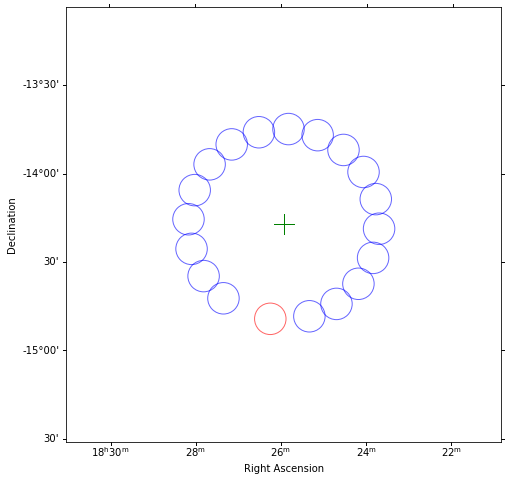

In [8]:
plt.figure(figsize=(8, 8))
obs3 = observations[3]
finder_list[3].plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7ff6392ed2b0>)

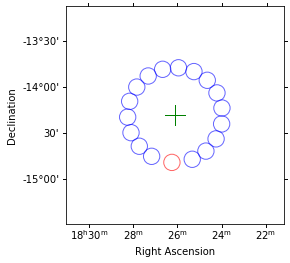

In [9]:
obs6 = observations[6]
finder_list[6].plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7ff639e1ddd8>)

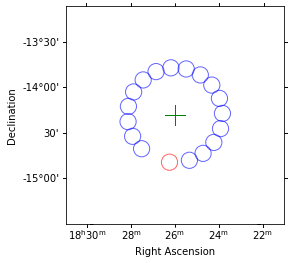

In [10]:
obs10 = observations[10]
finder_list[10].plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7ff6399238d0>)

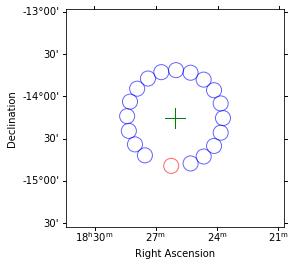

In [11]:
obs15 = observations[15]
finder_list[15].plot()

[Add %time at the begin]

What is left to do now is to create the empty dataset that will tells us the type of dataset that we want [i.e => SpectrumDataset (1D) or MapDataset (3D)]. Note here we don't have a background model, thus we can only define a SpectrumDataset background **NOTE: See Doc #9 for 1D dataset**

Also, we need to create the DatasetMaker, which will depends on the type of dataset we pick as empty_dataset. Also, the selection parameters is usually ["counts", "exposure", "psf", "edisp"], but for the "psf", "edisp", it depends if we have them in the hdu_table type.

We need to create the BackgroundMaker. In 3D, we pick RingBackgroundMaker and in 1D, we pick the ReflectedBackgroundMaker. 

We need to create the SafeMaskMaker. A methods we need to use is the offset-max with offset_max=3.5 u.deg and we would do well to have the aeff-max with aeff_percent = 10(or)20. Otherwise, maybe just add aeff-default method...

Also, if we have a 3D dataset, then we need to create a MapDatasetOnOff **NOTE: See Doc #9 for 1D dataset and Doc (Ring_Background) for 3D dataset.**.

#For Loop
We need to create a datasets list using Datasets(). Also, we need to runs the for loops of the observations and build the dataset of each obs and append them to the datasets list. 

Finally, we need to stacked_dataset_that_you_create.stack(dataset) after running the dataset on all makers. **Doc (Ring_Background) for 3D dataset.**






In [12]:
%time
#Create an empty 1D SpectrumDataset: Note here we don't have a background model, thus we can only define a SpectrumDataset background
e_reco = energy_axis
e_true = true_energy_axis
#Create an empty dataset that you will use for each observation
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)

# Create the DatasetMaker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])
# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask, max_region_number=6)
#Create a Safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)


# Create a stacked dataset
stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region, name="LS5039")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [13]:
%time
list_of_dataset = Datasets()
count = 0
for obs in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    list_of_dataset.append(dataset)
    stacked.stack(dataset)
    count+=1
# Making sure all the datasets are in the list
print(count==len(observations))
    


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
True


In [14]:
%time
for dataset in list_of_dataset:
    print(dataset)




CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
SpectrumDatasetOnOff
--------------------

  Name                            : 69123 

  Total counts                    : 13 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : 7.17

  Predicted counts                : 6.86
  Predicted background counts     : 6.86
  Predicted excess counts         : nan

  Exposure min                    : 1.17e+04 m2 s
  Exposure max                    : 5.28e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 69187 

  To


SpectrumDatasetOnOff
--------------------

  Name                            : 73370 

  Total counts                    : 14 
  Total off counts                : 38.00
  Total background counts         : 6.33
  Total excess counts             : 7.67

  Predicted counts                : 7.43
  Predicted background counts     : 7.43
  Predicted excess counts         : nan

  Exposure min                    : 3.33e+04 m2 s
  Exposure max                    : 6.49e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


SpectrumDatasetOnOff
--------------------

  Name                            : 73390 

  Total counts                    : 12 
  Total off counts         

In [15]:
info_table= list_of_dataset.info_table(cumulative=True)

In [16]:
#print(info_table["excess_rate"]*60)
#print(info_table["background_rate"]*60)
info_table


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
69123,13.0,5.833333333333333,7.166666666666667,2.3047694059162627,6.857142857142857,6.857142857142857,nan,11712.76966370375,527619945.640971,1622.2295077505962,1802.6912210285664,0.008013662640143911,0.0035958742616030367,0.004417788378540875,15,15,wstat,17.129228654888202,35.0,15.0,90.0,0.16666666666666663
69123,22.0,11.333333969116211,10.666666030883789,2.5451349723311236,12.85714318557661,12.85714318557661,nan,67486.27267436817,1241242375.0352812,3279.131181559589,3605.399575084448,0.0067090942026712605,0.003456200237687947,0.0032528939649833135,15,15,wstat,16.981508721398505,68.0,15.0,89.99999237060547,0.1666666716337204
69123,33.0,16.833332061767578,16.166667938232422,3.1577342963800508,19.142858058822387,19.142858058822387,nan,76152.99735346326,1773153305.0102699,4945.744809190062,5408.106763660908,0.006672402494095572,0.003403598994935665,0.003268803499159907,15,15,wstat,27.724888751531125,101.0,15.0,90.00000762939453,0.1666666716337204
69123,47.0,26.666667938232422,20.333332061767578,3.235379795995321,29.571430947099373,29.571430947099373,nan,126873.29047882506,2415228894.3015175,6540.669935996066,7210.786284387112,0.007185808252047573,0.004077054521811978,0.0031087537302355948,15,15,wstat,32.91841857466466,160.0,15.0,89.99999237060547,0.1666666865348816
69123,65.0,34.00000762939453,30.99999237060547,4.286065941862733,38.42857496105889,38.42857496105889,nan,138831.45734040803,2943260204.3473034,8127.777770256019,9013.506550610065,0.007997265899403713,0.004183186178369584,0.003814079721034129,15,15,wstat,40.33879082998484,204.0,15.0,89.9999771118164,0.16666670143604279
69123,69.0,41.00000762939453,27.99999237060547,3.6313600598208615,45.00000441196006,45.00000441196006,nan,151438.00169103296,3373176203.818906,9259.477801310048,10335.103254020214,0.007451824118012115,0.004427896314368158,0.003023927803643957,15,15,wstat,36.051936920461834,246.0,15.0,89.99998474121094,0.16666670143604279
69123,84.0,50.16667938232422,33.83332061767578,3.971376486165515,55.000005411858375,55.000005411858375,nan,250223.94405757793,4090763430.993975,11078.750838149166,12435.608788967133,0.007582082242589109,0.004528189153742639,0.0030538930888464703,15,15,wstat,45.31630539705818,301.0,15.0,89.9999771118164,0.16666670143604279
69123,96.0,54.00000762939453,41.99999237060547,4.686903844601783,60.00000513451431,60.00000513451431,nan,263041.26412578934,4421803312.431233,11957.3623515813,13455.739992558956,0.008028526457367456,0.004516046770319151,0.003512479687048305,15,15,wstat,60.667755509924454,324.0,15.0,89.99998474121094,0.16666670143604279


SpectrumDatasetOnOff
--------------------

  Name                            : LS5039 

  Total counts                    : 183 
  Total off counts                : 632.00
  Total background counts         : 105.33
  Total excess counts             : 77.67

  Predicted counts                : 116.43
  Predicted background counts     : 116.43
  Predicted excess counts         : nan

  Exposure min                    : 4.14e+09 cm2 s
  Exposure max                    : 9.24e+13 cm2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 95.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




(<matplotlib.axes._subplots.AxesSubplot at 0x7ff63a9226d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff63906cba8>)

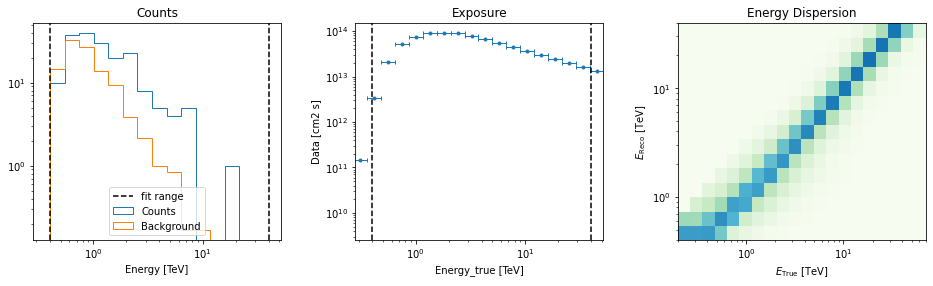

In [17]:
print(stacked)
stacked.peek()




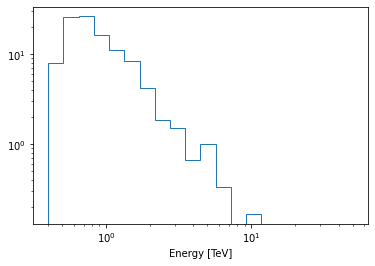

In [18]:
stacked.background.plot_hist()




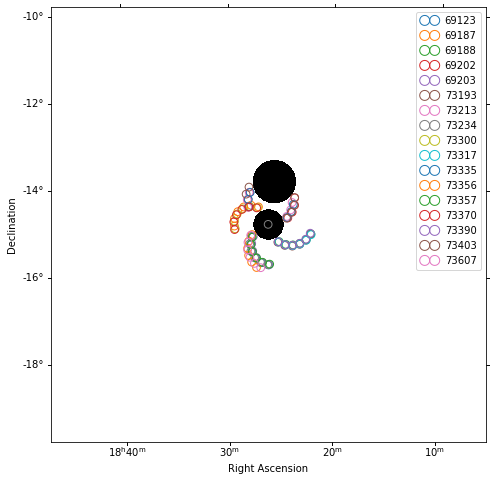

In [19]:
plt.figure(figsize=(8,8))
_, ax, _ = exclusion_mask.plot()

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="grey")
plot_spectrum_datasets_off_regions(ax=ax, datasets=list_of_dataset, legend=True)


In [18]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.502, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??z
sky_model = SkyModel(spectral_model=spectral_model, name = "LS5039")


In [19]:
models = Models(sky_model)

#list_of_dataset.models=models

for dataset in list_of_dataset:
    dataset.models=models


In [20]:
fit_joint = Fit(list_of_dataset)

In [21]:
%time
result_joint = fit_joint.run()
print(result_joint)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 91
	total stat : 186.98



In [23]:
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,1.7893e+00,,nan,nan,False,2.102e-01
amplitude,6.4438e-13,cm-2 s-1 TeV-1,nan,nan,False,1.263e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [1153]:
info_table = list_of_dataset.info_table(cumulative=True)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
69123,32.0,18.166666666666668,13.833333333333332,2.667160430190602,25.198111135224824,18.937867192689964,6.260243942534863,47428055.78601901,972428068.1373636,1622.2295077505962,1802.6912210285664,0.019725938806508088,0.011198579843278031,0.008527358963230059,20,20,wstat,14.11765180888761,109.0,20.0,119.99999999999999,0.16666666666666663
69123,51.0,35.166664123535156,15.833335876464844,2.275940403474522,42.66556154507195,36.40531760253709,6.260243942534863,187878223.08517176,2271584935.310478,3279.131181559589,3605.399575084448,0.015552900197101559,0.010724384654477143,0.004828515542624417,20,20,wstat,21.29845004232535,194.0,20.0,110.3317642211914,0.1812553107738495
69123,72.0,50.16666793823242,21.833332061767578,2.639377571106254,58.383408832159255,52.12316488962439,6.260243942534863,226664944.98871815,3242046480.9690733,4945.744809190062,5408.106763660908,0.014557969078026702,0.010143400008228071,0.0044145690697986305,20,20,wstat,25.713605562625506,284.0,20.0,113.22258758544922,0.17587800323963165
69123,114.0,76.41666412353516,37.583335876464844,3.6161323601920703,87.29075662817742,81.03051268564256,6.260243942534863,371964640.52547526,4417247104.397048,6540.669935996066,7210.786284387112,0.017429407249647304,0.011683308418145672,0.005746098831501631,20,20,wstat,34.53434968851344,389.0,20.0,101.81025695800781,0.19677402079105377
69123,148.0,94.91667175292969,53.08332824707031,4.551784862133425,108.03061096257346,101.7703670200386,6.260243942534863,423524178.1272927,5378588855.70905,8127.777770256019,9013.506550610065,0.0182091592786423,0.011678059419916925,0.006531099858725373,20,20,wstat,36.85813103084465,500.0,20.0,105.3555679321289,0.18892952799797058
69123,167.0,109.25,57.75,4.643834317397117,123.10151443738548,116.8412704948506,6.260243942534863,483978046.5564195,6149670470.742813,9259.477801310048,10335.103254020214,0.018035574314609032,0.011798721520185847,0.006236852794423183,20,20,wstat,33.86041326473103,586.0,20.0,107.27688598632812,0.18626634776592255
69123,196.0,134.5833282470703,61.41667175292969,4.462469149202068,149.6002710863739,143.34002714383905,6.260243942534863,675131846.178229,7492695942.2877865,11078.750838149166,12435.608788967133,0.017691525232707922,0.012147879324412537,0.005543645908295385,20,20,wstat,36.40001539545762,662.0,20.0,98.37771606445312,0.20061948895454407
69123,223.0,146.75,76.25,5.26434212946551,163.9455545911923,157.6853106486574,6.260243942534863,721481985.8966558,8088507894.391008,11957.3623515813,13455.739992558956,0.018649597916593152,0.012272773516861188,0.006376824399731963,20,20,wstat,54.663912784823914,735.0,20.0,100.17035675048828,0.19783559441566467


In [1154]:
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,1.8449e+00,,nan,nan,False,2.251e-01
amplitude,4.9801e-13,cm-2 s-1 TeV-1,nan,nan,False,1.019e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [1155]:
stacked.models = models
#stacked.model.parameters["lat_0"].frozen = True
#stacked.model.parameters["lon_0"].frozen = True

In [1156]:
fit_stacked = Fit(stacked)



In [1157]:
result_stacked = fit_stacked.run()

In [22]:
print(result_stacked)
result_stacked.parameters.to_table()

NameError: name 'result_stacked' is not defined

For the Orbital Phase. Note we got a binary system and the "intensity" of the flux we observe depends on where the sources is in its orbits. 

The orbital phase: (t_start - t_ref)/Period. ==> Then, you remove the integer (eg. 9.38 => 0.38 (removes the 9)). **Also, t_start corresponds obs.gti.time_start (it is in MDJ).**

The period is 3.9 day, which is 3.9 MDJ (Note). This data was extracted in the paper.
The reference time is: t0 = 51942.59 (**note it is not the same as obs.gti.time_ref**)


In [1196]:
#help(obs3.gti)
time_intervals=obs.gti.time_intervals

for obs in observations:
    #print(obs.gti.time_ref)
    #56455.3753140405, 56459.34299503474
    #56455.39617852223 56459.363859714766 56459.38553429703 56460.36354830713 56460.38513486053 56775.47694418295 56776.47205457098
    print(obs.gti.time_intervals[0][1])
    obs.gti.

56455.39617852223
56459.363859714766
56459.38553429703
56460.36354830713
56460.38513486053
56775.47694418295
56776.47205457098
56777.47030494414
56780.47245987165
56781.47191546665
56782.47097196915
56783.450307426276
56783.46955557774
56784.4691224256
56785.46942375241
56786.4689861072
56803.450346858604


In [ ]:
time_min	time_max
float64	float64


54729.15724563289	54729.17116056904
54729.1836596048	54729.19757541274
54730.11609051363	54730.13000675254
54737.26323636662	54737.27019567376
...	...
57331.076087903406	57331.09692472174
57331.09736786614	57331.11820406476
57332.08446441899	57332.10530111997
57333.08329323993	57333.104129135805
57334.0747518152	57334.09558837902
57510.42818764592	57510.44207870916
57511.41816588958	57511.43900237804
57512.41797707888	57512.432857995875
57546.29135411891	57546.2982990139
57552.327347891034	57552.34818470555